## Random Forest Tweet Sentiment Prediction

#### Import Modules

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd 
import re  
import nltk 
nltk.download('stopwords')  
from nltk.corpus import stopwords 
import jsonconfig as jsc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shepa135\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Set up database with credentials

In [2]:
# A database needs to be created already and user/password should be configured as well

# Import credentials from config file
psql_cred = jsc.json_config('config/psql_config.json')
dbname = psql_cred['psql']['dbname']
host = psql_cred['psql']['host']
port = psql_cred['psql']['port']
user = psql_cred['psql']['user']
password = psql_cred['psql']['password']

# Set up database connection
psql_connection = psycopg2.connect(dbname=dbname,
                   host= host,
                   port=port, 
                   user=user, 
                   password=password)


# Needed for connection
cursor = psql_connection.cursor()

# Print PostgreSQL Connection properties
print (psql_connection.get_dsn_parameters(),"\n")

{'user': 'cdog', 'dbname': 'twitter', 'host': '127.0.0.1', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



#### Fetch the Twitter Data Collected from the Twitter Stream Script

In [3]:
query = """
        SELECT * from twitter;

        """

cursor.execute(query)

# Fetch all records - different than inserting/creating because we want to get at the selection in python
data = cursor.fetchall()

#### Load in as a dataframe and reassign column names

In [4]:
tdf = pd.DataFrame(data)
tdf.columns = ['tid', 'date', 'timezone', 'name', 'userdesc', 
               'retweet','full_text', 'hashtag', 'coordinate',
              'geo', 'place', 'location', 'fav_count', 'quote_count',
              'reply_count', 'retweet_count', 'status_count', 'screen_name',
              'friends_count', 'lang', 'filterlevel', 'source', 'sensitive']
tdf.head()

,tid,date,timezone,name,userdesc,retweet,full_text,hashtag,coordinate,geo,...,quote_count,reply_count,retweet_count,status_count,screen_name,friends_count,lang,filterlevel,source,sensitive
0,1248315976925491200,Thu Apr 09 18:24:56 +0000 2020,None,Kim Wood,"Wife, Mummy & Nurse on a break to raise my 3 g...",True,[ @WYHpartnership: Good morning and thank you ...,[],None,None,...,0,0,0,24333,{Woodster44},1504,en,low,Twitter for iPhone,None
1,1248315978007687168,Thu Apr 09 18:24:56 +0000 2020,None,❕,hell bound but heaven sent,True,[ @SimonPeach: #MUFC have announced a package ...,[MUFC ],None,None,...,0,0,0,9478,{Jordun_},131,en,low,Twitter for iPhone,false
2,1248315978167005185,Thu Apr 09 18:24:56 +0000 2020,None,steve brown,None,False,[Another tragic death. My condolences to the f...,[],None,None,...,0,0,0,5551,{stevebr98325879},332,en,low,Twitter Web App,None
3,1248315978896867330,Thu Apr 09 18:24:56 +0000 2020,None,Anas Saadallah - أنس ✊✊✊,Belgo-Tunisien - Wikipédien - #新浪微博: http://t....,False,[Coronavirus (COVID-19) - NHS - NHS https://t....,[],None,None,...,0,0,0,102238,{anassaadallah},3744,en,low,iOS,false
4,1248315979555356673,Thu Apr 09 18:24:56 +0000 2020,None,Andrew McCullough,All my views are my own. Retweets are not endo...,True,[ @DrMamnunKhan: Please NHS workers sign up fo...,[],None,None,...,0,0,0,32420,{AndrewMuckaluck},2062,en,low,Twitter for iPhone,None


#### Example of a plot for Sentiment Around Tweets

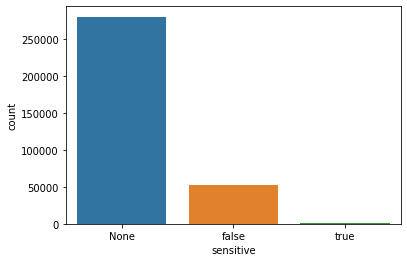

In [5]:
# Plotting example with seaborn
sns.countplot(x='sensitive', data=tdf)

#### Isolate the text values and remove everything except the text

In [6]:
# Values to predict (We have to build a training model before creating sentiments for these)
to_pred = tdf['full_text'].values

# Remove special characters fromt the tweets and add them to the list
processed_tweets = []

for tweet in range(0, len(to_pred)):  
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', str(to_pred[tweet][0]))

    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)

    # Remove single characters from the start
    processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 

    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)

    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)

    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()

    processed_tweets.append(processed_tweet)

#### Load in the Twitter training dataset and make minor adjsutments

In [7]:
# Training data - Downloaded from here https://www.kaggle.com/kazanova/sentiment140/data#
trainTweets_placeholder = [1,2,3,4,5,6]

trainTweets = pd.read_csv( 'trainingData/trainingDataTwitter.csv', encoding ='latin-1', header=trainTweets_placeholder)

# Dataset is 1.6 million tweets which fails on my computer 32GB of ram

# The dataset is sorted by positive and negative tweets. grab pos and neg tweets
# trainTweetsNeg = trainTweets.head(100000)
# trainTweetsPos = trainTweets.tail(100000)

# Merge the dataframes back together
# trainTweets = trainTweetsNeg.append(trainTweetsPos)

# Randomly samples a percentage of the tweets (1 is 100 percent)
trainTweets = trainTweets.sample(frac=.3)

# Assign Column headers
trainTweets.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
print("Tweet Table Shape", trainTweets.shape)
trainTweets.head()

Tweet Table Shape (479998, 6)


,target,ids,date,flag,user,text
1585037,4,2190632728,Tue Jun 16 03:17:17 PDT 2009,NO_QUERY,khriczk,Getting some stuff done meeting that girl at r...
1260060,4,1998248909,Mon Jun 01 18:14:20 PDT 2009,NO_QUERY,nikoflyagain13,http://twitpic.com/6fs0p - me eating cupcake
667830,0,2245736415,Fri Jun 19 16:33:54 PDT 2009,NO_QUERY,shandi_archie,@nickilambert Ahh. I'm sorry! that's really s...
1407991,4,2055620209,Sat Jun 06 09:39:01 PDT 2009,NO_QUERY,ErickaKristen,Awww I love the beach! U all want a picture......
365905,0,2048671834,Fri Jun 05 15:34:58 PDT 2009,NO_QUERY,m_pattix0,Is not feeling loved


#### Reassign values in the target column to text values for prediction

In [8]:
# Give numbers labels for interpretation
trainTweets['target'] = trainTweets['target'].map({0: "negative", 4: "positive"})

#### Isolate the sentiments from the training datasets and plot the pos/neg numbers to make sure they are balanced

(479998,) y-length


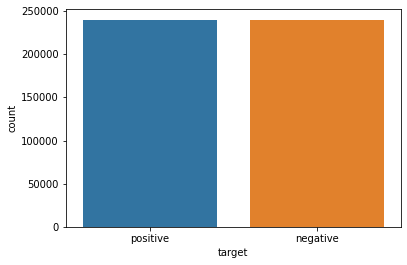

In [9]:
# Grab the sentiments for the tweets and assign it to a new variable
y = trainTweets.iloc[:, 0].values
print(y.shape, "y-length")

# Plot the data to understand the distribution/no problems are immediately present
sns.countplot(x='target', data=trainTweets)

#### Preview the column to make sure the right column was selected

In [10]:
y

array(['positive', 'positive', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

#### Isolate the text values of the training dataset and filter out special characters

In [11]:
Train_X = trainTweets['text'].values

# Remove special characters fromt the tweets and add them to the list
processed_tweets_train = []

for tweet in range(0, len(Train_X)):  
    # Remove all the special characters
    processed_tweet_train = re.sub(r'\W', ' ', str(Train_X[tweet]))

    # remove all single characters
    processed_tweet_train = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet_train)

    # Remove single characters from the start
    processed_tweet_train = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet_train) 

    # Substituting multiple spaces with single space
    processed_tweet_train= re.sub(r'\s+', ' ', processed_tweet_train, flags=re.I)

    # Removing prefixed 'b'
    processed_tweet_train = re.sub(r'^b\s+', '', processed_tweet_train)

    # Converting to Lowercase
    processed_tweet_train = processed_tweet_train.lower()

    processed_tweets_train.append(processed_tweet_train)

#### Transform the list of tweet descriptions 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer  

tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(processed_tweets_train).toarray()

#### Check the shape to ensure each x/y is the same length

In [13]:
# These need to be the same shape for prediction
print("X-Shape", X.shape, "\nY-Shape", y.shape)

X-Shape (479998, 2000) 
Y-Shape (479998,)


In [14]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [16]:
predictions = text_classifier.predict(X_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[35210 12671]
 [11640 36479]]
              precision    recall  f1-score   support

    negative       0.75      0.74      0.74     47881
    positive       0.74      0.76      0.75     48119

    accuracy                           0.75     96000
   macro avg       0.75      0.75      0.75     96000
weighted avg       0.75      0.75      0.75     96000

0.7467604166666667


In [18]:
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X_predict = tfidfconverter.fit_transform(processed_tweets).toarray()

In [30]:
predictions = text_classifier.predict(X_predict)
predictions

array(['negative', 'positive', 'positive', ..., 'negative', 'negative',
       'positive'], dtype=object)

In [31]:
# Change to a dataframe
pred_df = pd.DataFrame(data=predictions)
pred_df.columns = ['sentiment']
pred_df.head()

,sentiment
0,negative
1,positive
2,positive
3,positive
4,positive


In [32]:
pred_df.shape

(333659, 1)

In [33]:
tdf.shape

(333659, 24)

In [34]:
tdf['sentiment'] = pred_df
tdf

,tid,date,timezone,name,userdesc,retweet,full_text,hashtag,coordinate,geo,...,reply_count,retweet_count,status_count,screen_name,friends_count,lang,filterlevel,source,sensitive,sentiment
0,1248315976925491200,Thu Apr 09 18:24:56 +0000 2020,None,Kim Wood,"Wife, Mummy & Nurse on a break to raise my 3 g...",True,[ @WYHpartnership: Good morning and thank you ...,[],None,None,...,0,0,24333,{Woodster44},1504,en,low,Twitter for iPhone,None,negative
1,1248315978007687168,Thu Apr 09 18:24:56 +0000 2020,None,❕,hell bound but heaven sent,True,[ @SimonPeach: #MUFC have announced a package ...,[MUFC ],None,None,...,0,0,9478,{Jordun_},131,en,low,Twitter for iPhone,false,positive
2,1248315978167005185,Thu Apr 09 18:24:56 +0000 2020,None,steve brown,None,False,[Another tragic death. My condolences to the f...,[],None,None,...,0,0,5551,{stevebr98325879},332,en,low,Twitter Web App,None,positive
3,1248315978896867330,Thu Apr 09 18:24:56 +0000 2020,None,Anas Saadallah - أنس ✊✊✊,Belgo-Tunisien - Wikipédien - #新浪微博: http://t....,False,[Coronavirus (COVID-19) - NHS - NHS https://t....,[],None,None,...,0,0,102238,{anassaadallah},3744,en,low,iOS,false,positive
4,1248315979555356673,Thu Apr 09 18:24:56 +0000 2020,None,Andrew McCullough,All my views are my own. Retweets are not endo...,True,[ @DrMamnunKhan: Please NHS workers sign up fo...,[],None,None,...,0,0,32420,{AndrewMuckaluck},2062,en,low,Twitter for iPhone,None,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333654,1248602645167845376,Fri Apr 10 13:24:03 +0000 2020,None,Terence Bermingham,Sports fan who is a member @surreycricket & a ...,True,[ @carolecadwalla: GIVE. THEM. PROTECTIVE. EQU...,[],None,None,...,0,0,2076,{tpbermingham},63,en,low,Twitter for iPhone,None,positive
333655,1248602645662535681,Fri Apr 10 13:24:03 +0000 2020,None,RemainVoter #FBPE,Not accepting defeat graciously. The Rejoin EU...,True,[ @ChantelleSeddon: I am grateful for NHS staf...,[],None,None,...,0,0,482,{VoterRemain},799,en,low,Twitter for iPhone,None,positive
333656,1248602646170275841,Fri Apr 10 13:24:03 +0000 2020,None,Lois Garnett,twenty-two|manchester,True,[ @liamgallagher: It's an honour to announce t...,[],None,None,...,0,0,18900,{loisgarnett_},1100,en,low,Twitter for iPhone,None,negative
333657,1248602647424372736,Fri Apr 10 13:24:03 +0000 2020,None,Paul,Celtic + CVFC OK,True,[ @liamgallagher: It's an honour to announce t...,[],None,None,...,0,0,2831,{Youreds1888},975,en,low,Twitter for iPhone,None,negative
